In [2]:
import pandas as pd 
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt
import pathlib
import zipfile
from typing import Tuple, Dict, List
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F
from PIL import Image, ImageEnhance
from torchvision import transforms
from typing import Tuple, Dict, List
from torch.utils.data import DataLoader
import shutil
import splitfolders
#pathlib.Path('models').mkdir(parents=True, exist_ok=True) 
#pathlib.Path('plots').mkdir(parents=True, exist_ok=True)
#%matplotlib inline 

In [19]:
dataset_dir = "C:/LMU/python/SEP_DLCV/Final_project/last_work/Blumen"
file_name = 'data'
data_path = dataset_dir + '/' + file_name

with zipfile.ZipFile(str(data_path) + ".zip", 'r') as zip_ref:
    zip_ref.extractall(str(dataset_dir)+'/')


In [23]:
percentage = float(input("Enter percentage of training data? "))/100

output = f"{data_path}set"+f"\\{file_name}"

splitfolders.ratio(data_path, output=output, ratio=(percentage, (1 - percentage)/2 , (1 - percentage)/2), group_prefix=None, move=False)
# for info: ratio(train, valid, test)


Copying files: 600 files [00:00, 691.45 files/s]


In [24]:

print('#'*51)
print('################## training data ##################')
print('#'*51)



def detect_crop_face(image):
    # Load the pre-trained Haar cascade classifier for face detection
    face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    
    # Detect faces in the image
    face = face_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
    
    # Draw rectangles around the detected faces
    for (x, y, w, h) in face:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 10)
        # Crop face region from the original image
        face_region = image[y:y+h, x:x+w]
    
    return face_region


#############################################################
#############################################################


train_DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/Blumen/dataset/data/train"

class_labels = ['sommeraster', 'sonnenblume', 'tellerkraeuter']

X_train, y_train = [], []
classes_count = 0 

for folder in os.listdir(train_DS_path):
    if folder in class_labels:
        print(folder)
        for img in os.listdir(os.path.join(train_DS_path, folder)):
            if img.endswith('jpg') or img.endswith('jpeg') or img.endswith('png'):
                try:
                    to_append = cv2.imread(os.path.join(train_DS_path, folder, img))
                    #to_append = detect_crop_face(img) -> already done!
                    to_append = cv2.resize(to_append,(299,299))
                    X_train.append(to_append)
                    y_train.append(classes_count)
                except Exception as e: 
                    print(e)
        classes_count += 1

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

##########################################################

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(X_train)

for i in range(numSamples):
    im = np.array(X_train[i])
    im = im.astype(float) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for i in range(numSamples):
    im = np.array(X_train[i])
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += np.sum((im[:, :, j] - mean[j]) ** 2) / (im.shape[0] * im.shape[1])

std = np.sqrt(stdTemp/numSamples)

mean_train_ds = mean
std_train_ds = std
print("mean of dataset: ", mean_train_ds)
print("std of dataset: ",std_train_ds)


###################################################
################## training data ##################
###################################################
sommeraster
sonnenblume
tellerkraeuter
(420, 299, 299, 3)
(420,)
mean of dataset:  [0.30535315 0.41391235 0.45806665]
std of dataset:  [0.28787089 0.25270014 0.28634693]


In [27]:

print('#'*51)
print('################## testing data ##################')
print('#'*51)

test_DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/Blumen/dataset/data/test"

X_test, y_test = [], []
classes_count = 0 

for folder in os.listdir(test_DS_path):
    if folder in class_labels:
        print(folder)
        for img in os.listdir(os.path.join(test_DS_path, folder)):
            if img.endswith('jpg') or img.endswith('jpeg') or img.endswith('png'):
                try:
                    to_append = cv2.imread(os.path.join(test_DS_path, folder, img))
                    #to_append = detect_crop_face(img) -> already done!
                    to_append = cv2.resize(to_append,(299,299))
                    X_test.append(to_append)
                    y_test.append(classes_count)
                except Exception as e: 
                    print(e)
        classes_count += 1

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape)
print(y_test.shape)

##########################################################

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(X_test)

for i in range(numSamples):
    im = np.array(X_test[i])
    im = im.astype(float) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for i in range(numSamples):
    im = np.array(X_test[i])
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += np.sum((im[:, :, j] - mean[j]) ** 2) / (im.shape[0] * im.shape[1])

std = np.sqrt(stdTemp/numSamples)

mean_test_ds = mean
std_test_ds = std
print("mean of dataset: ", mean_test_ds)
print("std of dataset: ",std_test_ds)

###################################################
################## testing data ##################
###################################################
sommeraster
sonnenblume
tellerkraeuter
(90, 299, 299, 3)
(90,)
mean of dataset:  [0.2894377  0.38989867 0.43642129]
std of dataset:  [0.28610249 0.25381715 0.29168037]


In [28]:

print('#'*51)
print('################## validation data ##################')
print('#'*51)

valid_DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/Blumen/dataset/data/val"

X_valid, y_valid = [], []
classes_count = 0 

for folder in os.listdir(valid_DS_path):
    if folder in class_labels:
        print(folder)
        for img in os.listdir(os.path.join(valid_DS_path, folder)):
            if img.endswith('jpg') or img.endswith('jpeg') or img.endswith('png'):
                try:
                    to_append = cv2.imread(os.path.join(valid_DS_path, folder, img))
                    #to_append = detect_crop_face(img) -> already done!
                    to_append = cv2.resize(to_append,(299,299))
                    X_valid.append(to_append)
                    y_valid.append(classes_count)
                except Exception as e: 
                    print(e)
        classes_count += 1

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
print(X_valid.shape)
print(y_valid.shape)

##########################################################

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(X_valid)

for i in range(numSamples):
    im = np.array(X_valid[i])
    im = im.astype(float) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for i in range(numSamples):
    im = np.array(X_valid[i])
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += np.sum((im[:, :, j] - mean[j]) ** 2) / (im.shape[0] * im.shape[1])

std = np.sqrt(stdTemp/numSamples)

mean_valid_ds = mean
std_valid_ds = std
print("mean of dataset: ", mean_valid_ds)
print("std of dataset: ",std_valid_ds)


###################################################
################## validation data ##################
###################################################
sommeraster
sonnenblume
tellerkraeuter
(90, 299, 299, 3)
(90,)
mean of dataset:  [0.31793696 0.41693488 0.46246746]
std of dataset:  [0.29421616 0.2598702  0.29309385]


In [32]:
from torchvision import datasets
from torch.utils.data import DataLoader


train_transform = transforms.Compose([ 
    #transforms.RandomResizedCrop(size=64,  scale=(0.1, 1.1), ratio=(0.75, 1.333)),
    transforms.Resize(size=(299, 299)),
    #transforms.Grayscale(),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train_ds, std=std_train_ds) 
])


test_transform = transforms.Compose([
    transforms.Resize(size=(299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_test_ds, std=std_test_ds)
])

valid_transform = transforms.Compose([
    transforms.Resize(size=(299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_valid_ds, std=std_valid_ds)
])

train_data = datasets.ImageFolder(root=train_DS_path,
                                  transform=train_transform)

test_data = datasets.ImageFolder(root=test_DS_path, 
                                 transform=test_transform)

valid_data = datasets.ImageFolder(root=valid_DS_path, 
                                  transform=valid_transform)


In [33]:
# dataloader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=8, 
                              num_workers=4, 
                              shuffle=True) 
img, label = next(iter(train_dataloader))
print(f"Train batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=8, 
                             num_workers=1, 
                             shuffle=False) 
img, label = next(iter(test_dataloader))
print(f"Test batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


valid_dataloader = DataLoader(dataset=valid_data, 
                             batch_size=8, 
                             num_workers=1, 
                             shuffle=False) 
img, label = next(iter(valid_dataloader))
print(f"Valid batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Train batch: Image shape: torch.Size([8, 3, 299, 299]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])
Test batch: Image shape: torch.Size([8, 3, 299, 299]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])
Valid batch: Image shape: torch.Size([8, 3, 299, 299]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


In [34]:

class BlumenDetector(nn.Module):
    def __init__(self):
        super(BlumenDetector, self).__init__()

        # 1st Convolutional layer
        self.conv1_1 = nn.Conv2d(3, 48, kernel_size=(3, 3), padding=1)
        self.bn1_1 = nn.BatchNorm2d(48)
        self.conv1_2 = nn.Conv2d(48, 48, kernel_size=(3, 3), padding=1)
        self.bn1_2 = nn.BatchNorm2d(48)
        self.conv1_3 = nn.Conv2d(48, 48, kernel_size=(3, 3), padding=1)
        self.bn1_3 = nn.BatchNorm2d(48)


        # 2nd Convolutional layer
        self.conv2_1 = nn.Conv2d(48, 64, kernel_size=(3, 3), padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.conv2_3 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.bn2_3 = nn.BatchNorm2d(64)


        # 3rd Convolutional layer
        self.conv3_1 = nn.Conv2d(64, 80, kernel_size=(3, 3), padding=1)
        self.bn3_1 = nn.BatchNorm2d(80)
        self.conv3_2 = nn.Conv2d(80, 80, kernel_size=(3, 3), padding=1)
        self.bn3_2 = nn.BatchNorm2d(80)
        self.conv3_3 = nn.Conv2d(80, 80, kernel_size=(3, 3), padding=1)
        self.bn3_3 = nn.BatchNorm2d(80)


        # 4th Convolutional layer
        self.conv4_1 = nn.Conv2d(80, 126, kernel_size=(3, 3), padding=1)
        self.bn4_1 = nn.BatchNorm2d(126)
        self.conv4_2 = nn.Conv2d(126, 126, kernel_size=(3, 3), padding=1)
        self.bn4_2 = nn.BatchNorm2d(126)
        self.conv4_3 = nn.Conv2d(126, 126, kernel_size=(3, 3), padding=1)
        self.bn4_3 = nn.BatchNorm2d(126)
        

        # pool layers
        self.pool1 = nn.MaxPool2d(3, 1)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(3, 3)
        self.gapool = nn.AdaptiveAvgPool2d(output_size=(1, 1))


        # Fully connected layers
        self.fc = nn.Linear(126, 6)


    def forward(self, x):

        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = F.relu(self.bn1_3(self.conv1_3(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = F.relu(self.bn2_3(self.conv2_3(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = F.relu(self.bn3_3(self.conv3_3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = F.relu(self.bn4_3(self.conv4_3(x)))
        x = self.gapool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x


In [36]:

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = BlumenDetector().to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.e-1)

tolerance = 7
best_val_acc = 0
tolerance_counter = 0


num_epochs = 80

train_losses = []
test_losses = []
val_losses = []
train_accuracies = []
test_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # 1. Optimizer Gradient Reset:
        optimizer.zero_grad()

        # 2. Forward Pass:
        outputs = model(inputs)

        # 3. Loss Calculation:
        loss = criterion(outputs, labels)

        # 4. Backward Pass:
        loss.backward()

        # 5. Parameter Update:
        optimizer.step()

        # 6.Loss Accumulation:
        running_loss += loss.item()

        # 7.Prediction Extraction: torch.max returns both 
        # maximum values and their indices, but only indices 
        # (predicted) are needed for comparison with true 
        # labels.
        _, predicted = torch.max(outputs.data, 1)

        # 8.Total Count:
        total += labels.size(0)

        # 9.Correct Count:
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)


    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(test_dataloader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)


    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in valid_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(valid_dataloader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy:{train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        tolerance_counter = 0
        torch.save(model.state_dict(), 'C:/LMU/python/SEP_DLCV/Final_project/last_work/models/blumenDetector_state_dict002.pth')
    else:
        tolerance_counter += 1
        print(f"No improvement in validation accuracy for {tolerance_counter}epochs.")

    if tolerance_counter > tolerance :
        print("Stopping early due to lack of improvement in validation accuracy.")
        break


Epoch 1/80:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/80: 100%|██████████| 53/53 [06:02<00:00,  6.83s/it]


Epoch 1, Train Loss: 0.906355729642904, Train Accuracy:0.6285714285714286, Test Loss: 0.5861934120766819, Test Accuracy: 0.8222222222222222, Validation Loss: 0.5455691839257876, Validation Accuracy: 0.8444444444444444


Epoch 2/80: 100%|██████████| 53/53 [05:00<00:00,  5.68s/it]


Epoch 2, Train Loss: 0.7538502699923966, Train Accuracy:0.7023809523809523, Test Loss: 1.1797068640589714, Test Accuracy: 0.6222222222222222, Validation Loss: 1.0465571843087673, Validation Accuracy: 0.6444444444444445
No improvement in validation accuracy for 1epochs.


Epoch 3/80: 100%|██████████| 53/53 [05:11<00:00,  5.87s/it]


Epoch 3, Train Loss: 0.736640418194375, Train Accuracy:0.6880952380952381, Test Loss: 0.48794544984896976, Test Accuracy: 0.8222222222222222, Validation Loss: 0.4547238281617562, Validation Accuracy: 0.8222222222222222
No improvement in validation accuracy for 2epochs.


Epoch 4/80: 100%|██████████| 53/53 [05:10<00:00,  5.86s/it]


Epoch 4, Train Loss: 0.6709444868677067, Train Accuracy:0.7142857142857143, Test Loss: 0.5537960032622019, Test Accuracy: 0.8111111111111111, Validation Loss: 0.512479268014431, Validation Accuracy: 0.8111111111111111
No improvement in validation accuracy for 3epochs.


Epoch 5/80: 100%|██████████| 53/53 [05:13<00:00,  5.92s/it]


Epoch 5, Train Loss: 0.6241095608697748, Train Accuracy:0.75, Test Loss: 0.6163662131875753, Test Accuracy: 0.7444444444444445, Validation Loss: 0.6215947133799394, Validation Accuracy: 0.7444444444444445
No improvement in validation accuracy for 4epochs.


Epoch 6/80: 100%|██████████| 53/53 [05:10<00:00,  5.86s/it]


Epoch 6, Train Loss: 0.6280081494236892, Train Accuracy:0.7380952380952381, Test Loss: 0.5643778747568527, Test Accuracy: 0.8444444444444444, Validation Loss: 0.39087207180758315, Validation Accuracy: 0.8666666666666667


Epoch 7/80: 100%|██████████| 53/53 [05:11<00:00,  5.87s/it]


Epoch 7, Train Loss: 0.7199899946462434, Train Accuracy:0.7166666666666667, Test Loss: 0.554767849544684, Test Accuracy: 0.8, Validation Loss: 0.504940445224444, Validation Accuracy: 0.8222222222222222
No improvement in validation accuracy for 1epochs.


Epoch 8/80: 100%|██████████| 53/53 [05:11<00:00,  5.89s/it]


Epoch 8, Train Loss: 0.6247472591557592, Train Accuracy:0.7523809523809524, Test Loss: 0.4868088358392318, Test Accuracy: 0.8, Validation Loss: 0.4585794347027938, Validation Accuracy: 0.8111111111111111
No improvement in validation accuracy for 2epochs.


Epoch 9/80: 100%|██████████| 53/53 [05:10<00:00,  5.87s/it]


Epoch 9, Train Loss: 0.5513833218588019, Train Accuracy:0.7833333333333333, Test Loss: 0.4556421361242731, Test Accuracy: 0.8888888888888888, Validation Loss: 0.46637455001473427, Validation Accuracy: 0.8444444444444444
No improvement in validation accuracy for 3epochs.


Epoch 10/80: 100%|██████████| 53/53 [05:10<00:00,  5.86s/it]


Epoch 10, Train Loss: 0.5915756383032169, Train Accuracy:0.780952380952381, Test Loss: 0.4662196102241675, Test Accuracy: 0.8222222222222222, Validation Loss: 0.41733064999183017, Validation Accuracy: 0.8333333333333334
No improvement in validation accuracy for 4epochs.


Epoch 11/80: 100%|██████████| 53/53 [05:08<00:00,  5.82s/it]


Epoch 11, Train Loss: 0.5541643833495536, Train Accuracy:0.780952380952381, Test Loss: 0.4269033515204986, Test Accuracy: 0.8, Validation Loss: 0.4401651273171107, Validation Accuracy: 0.8111111111111111
No improvement in validation accuracy for 5epochs.


Epoch 12/80: 100%|██████████| 53/53 [05:02<00:00,  5.70s/it]


Epoch 12, Train Loss: 0.5403368928522434, Train Accuracy:0.7785714285714286, Test Loss: 0.6272109391478201, Test Accuracy: 0.8222222222222222, Validation Loss: 0.46968062594532967, Validation Accuracy: 0.8444444444444444
No improvement in validation accuracy for 6epochs.


Epoch 13/80: 100%|██████████| 53/53 [05:01<00:00,  5.69s/it]


Epoch 13, Train Loss: 0.6297653607040081, Train Accuracy:0.7666666666666667, Test Loss: 0.4603135275344054, Test Accuracy: 0.7888888888888889, Validation Loss: 0.4339806502684951, Validation Accuracy: 0.8444444444444444
No improvement in validation accuracy for 7epochs.


Epoch 14/80: 100%|██████████| 53/53 [04:59<00:00,  5.65s/it]


Epoch 14, Train Loss: 0.5881014216058659, Train Accuracy:0.7785714285714286, Test Loss: 0.5285653074582418, Test Accuracy: 0.8222222222222222, Validation Loss: 0.4924233481287956, Validation Accuracy: 0.8111111111111111
No improvement in validation accuracy for 8epochs.
Stopping early due to lack of improvement in validation accuracy.


### Grad-CAM

In [4]:
from myModel import BlumenDetector

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = BlumenDetector()
model.load_state_dict(torch.load("C:/LMU/python/SEP_DLCV/Final_project/last_work/models/blumenDetector_state_dict002.pth"))
model.to(device)
model.eval()  

BlumenDetector(
  (conv1_1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [16]:

img_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/models/samples/Art1031.jpg"


def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess(img).unsqueeze(0)  
    return img

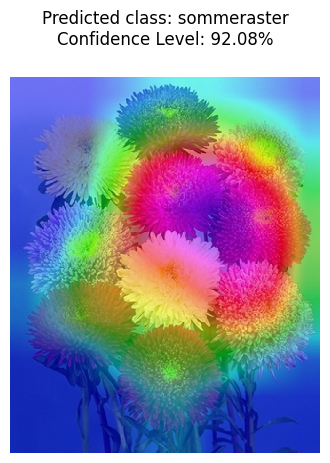

In [17]:
class_names = ['sommeraster', 'sonnenblume', 'tellerkraeuter']

class Hook():
    def __init__(self):
        self.hook_forward = None
        self.hook_backward = None
        self.forward_out = None
        self.backward_out = None

    def hook_fn_forward(self, module, input, output):
        self.forward_out = output

    def hook_fn_backward(self, module, grad_input, grad_output):
        self.backward_out = grad_output[0] 

    def register_hook(self, module):
        self.hook_forward = module.register_forward_hook(self.hook_fn_forward)
        self.hook_backward = module.register_full_backward_hook(self.hook_fn_backward)

    def unregister_hook(self):
        self.hook_forward.remove()
        self.hook_backward.remove()

final_layer = model.conv4_3 # change here conv6 for VGG16
hook = Hook()
hook.register_hook(final_layer)

img_tensor = preprocess_image(img_path)
logits = model(img_tensor)
probabilities = F.softmax(logits, dim=1)

# Get the top probability and its corresponding class index
top_prob, predicted_class = torch.max(probabilities, dim=1)  # Returns a tuple

predicted_class_idx = predicted_class.item()
predicted_class_name = class_names[predicted_class_idx]

one_hot_output = torch.FloatTensor(1, probabilities.shape[1]).zero_()
one_hot_output[0][predicted_class_idx] = 1
logits.backward(one_hot_output, retain_graph=True)

gradients = hook.backward_out
feature_maps = hook.forward_out

hook.unregister_hook()

weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
cam = torch.sum(weights * feature_maps, dim=1, keepdim=True)
cam = cam.clamp(min=0).squeeze() 

cam -= cam.min()
cam /= cam.max()
cam = cam.cpu().detach().numpy()
cam = cv2.resize(cam, (64, 64))

original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Resize CAM to match the original image dimensions
cam_resized = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))

# Normalize CAM to [0, 255]
cam_normalized = (cam_resized * 255).astype(np.uint8)

# Apply colormap (jet) to CAM
cam_colored = cv2.applyColorMap(cam_normalized, cv2.COLORMAP_HSV)

# Convert original image to uint8
original_img_uint8 = original_img.astype(np.uint8)

# Combine original image and CAM using weighted addition
combined_img = cv2.addWeighted(original_img_uint8, 0.5, cam_colored, 0.5, 0)

# Convert top probability to percentage (assuming probabilities are between 0 and 1)
confidence_percentage = top_prob.item() * 100

# Display combined image
plt.matshow(combined_img)
plt.title(f'Predicted class: {predicted_class_name}'+'\n'+f'Confidence Level: {confidence_percentage:.2f}%')
plt.axis('off')
plt.show()

### Boundry Class Mapping

Bounding box coordinates: [331, 312, 630, 700]


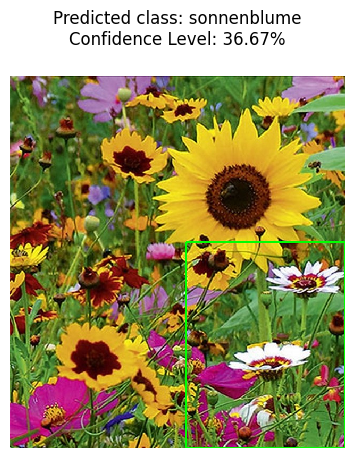

In [13]:
import cv2
import numpy as np

def threshold_cam(cam, threshold):
  """
  Applies a threshold to the CAM and returns the thresholded version.

  Args:
      cam: A NumPy array representing the CAM.
      threshold: A float value between 0 and 1 representing the threshold proportion.

  Returns:
      A NumPy array representing the thresholded CAM.
  """
  thresholded_cam = np.where(cam > threshold * cam.max(), 1, 0)
  return thresholded_cam


thresholded_cam = threshold_cam(cam, 0.2)


def get_segmentation_map(thresholded_cam):
  """
  Converts the thresholded CAM into a binary segmentation map.

  Args:
      thresholded_cam: A NumPy array representing the thresholded CAM.

  Returns:
      A NumPy array representing the segmentation map (0: background, 1: foreground).
  """
  segmentation_map = thresholded_cam.astype(np.uint8)
  return segmentation_map


segmentation_map = get_segmentation_map(thresholded_cam)


def get_bounding_box(segmentation_map):
  """
  Finds the largest connected component in the segmentation map and returns its bounding box.

  Args:
      segmentation_map: A NumPy array representing the segmentation map.

  Returns:
      A list containing the coordinates of the bounding box for the largest component 
      or None if no component is found.
  """

  # Ensure segmentation_map is in uint8 format
  segmentation_map = segmentation_map.astype(np.uint8)

  contours, _ = cv2.findContours(segmentation_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if not contours:
    return None
  # Find the largest contour
  largest_contour = max(contours, key=cv2.contourArea)
  # Get bounding box of the largest contour
  x, y, w, h = cv2.boundingRect(largest_contour)
  return [x, y, x + w, y + h]

#img_path = "C:/LMU/python/SEP_DLCV/Final_project/data_model/project/obama-855.jpg"
cam = combined_img
threshold = 0.2
thresholded_cam = threshold_cam(cam_resized, threshold)
segmentation_map = get_segmentation_map(thresholded_cam)
bounding_box = get_bounding_box(segmentation_map)
print("Bounding box coordinates:", bounding_box)

# Define the function to draw bounding box on the original image
def draw_bounding_box(image, bounding_box):
    x1, y1, x2, y2 = bounding_box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw rectangle
    return image


# Load the original image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Draw bounding box on the original image
image_with_box = draw_bounding_box(original_img.copy(), bounding_box)

# Display combined image
plt.matshow(image_with_box)
plt.title(f'Predicted class: {predicted_class_name}'+'\n'+f'Confidence Level: {confidence_percentage:.2f}%')
plt.axis('off')
plt.show()